#ISMRM Member Initiated Tutorial - Cardiac MR
##Physics coding challenge

Authors: Maša Božić, Chiara Coletti, Sebastian Weingärtner (*TU Delft, Delft, The Netherlands*)

---




This notebook contains a simple MRI simulator which can be used to define a custom pulse sequence and simulate an image acquisition on a phantom.

During this tutorial we will simulate a spoiled GRE sequence on a cardiac phantom and we will observe the effects of blood flow. 

**Some remarks**: the simulation does not take into account off-resonance effects nor relaxation contribution. 


!------------------------- DO NOT MODIFY THIS SECTION -------------------------!
# Simulator 
This section contains the functions and classes needed to run  the simulation.
*You should not modify these classes and functions to implement your solution.*

## Utilities
Some code cells to import necessary libraries, define auxiliary functions and the visualization function `plotMulti` which allows to display and compare multiple images in a single figure.

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.transform import resize, rescale
import scipy
import copy

In [ ]:
# Rotation functions along cardinal axes
# Input:
#   alpha: rotation angle [radians] 
# Output:
#   R: rotation matrix
def rotX(alpha):
  R = np.array([[1, 0, 0], [0, np.cos(alpha), np.sin(alpha)], [0, -np.sin(alpha), np.cos(alpha)]])
  return R

def rotY(alpha):
  R = np.array([[np.cos(alpha), 0, -np.sin(alpha)], [0, 1, 0], [np.sin(alpha), 0, np.cos(alpha)]])
  return R

def rotZ(alpha):
  R = np.array([[np.cos(alpha), np.sin(alpha), 0], [-np.sin(alpha), np.cos(alpha), 0], [0, 0, 1]])
  return R


In [ ]:
# Visualization function to compare 3 images
# Input:
#   imgs [img1, img2, img3]:        Input images
#   [title1, title2, title3]:  Respective titles
def plotMulti(imgs, titles):

  # Number of subplots
  n = len(imgs)

  # Plot
  plt.figure(figsize = [15, 5])

  for i in range(len(imgs)):
    plt.subplot(1, n, i + 1)
    plt.imshow(imgs[i], cmap='gray')
    plt.axis('off')
    plt.title(titles[i])
  
  plt.plot()

## Phantom
Numerical cardiac phantom in short axis view

In [ ]:
# Read in phantom as a matrix
val = '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 3 3 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 0.800000011920929 1 1 1 1 3 3 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0 0 0 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0 0 0 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071;0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071 0.699999988079071'

# Set and rescale 2D phantom
phantom2D = np.matrix(val)
phantom2D = rescale(phantom2D, 0.205, anti_aliasing=False)

## Image & k-Space 
The `isoGrid` class implements the geometrical objects used as inputs/outputs for the pulse sequence simulations and their auxiliary functions. These include:
- `M0`: input 3D isochromat grid
- `velAccMap`: flow properties map for the isochromat grid
- `kSpace`: k space grid, computed during the sequence simulation




In [ ]:
# Class to hold the input image and ouput k-Space
class isoGrid:

  # Constructor: Initialize with phantom image
  # Input:
  #   phantom: Matrix initialization
  def __init__(self, phantom = np.zeros((128, 128))):

    # Write input data to isochromat grid array
    M0 = np.zeros((phantom.shape[0], phantom.shape[1], 1, 3))
    M0[:,:,0,2] = phantom
    self.M0 = np.array(M0)

    # Calculate velocity/acceleration maps for flow-simulations
    self.velAccMap()

    # Initialize empty k-space
    self.kSpace = np.zeros((self.M0.shape[0], self.M0.shape[1]), dtype=complex)

  # Initialize flow velocity and acceleration maps
  def velAccMap(self):

    # Initialize empty arrays
    self.vGrid = np.zeros_like(self.M0)
    self.aGrid = np.zeros_like(self.M0)

    # Set velocity and acceleration vectors for blood and myocardium
    vBlood = np.array([0.4, 0.8, 0]) # [m/s]
    aBlood = np.array([0.02, 0.08, 0]) # [m/s^2]
    vMyo = np.array([0.1, 0.1, 0]) # [m/s]
    aMyo = np.array([0.005, 0.005, 0]) # [m/s^2]
    
    # Set v and a properties to blood and myocardium pixels
    I_Blood = 1 # phantom intensity in ventricles
    I_Myo = 0.800000011920929 # phantom intensity in myocardium
    for i in range(self.vGrid.shape[0]):
      for j in range(self.vGrid.shape[1]):
        for k in range(self.vGrid.shape[2]):
          if self.M0[i, j, k, 2] == I_Blood:
            self.vGrid[i,j,k,:] = vBlood
            self.aGrid[i,j,k,:] = aBlood
          elif self.M0[i, j, k, 2] == I_Myo:
            self.vGrid[i,j,k,:] = vMyo
            self.aGrid[i,j,k,:] = aMyo

  # Get center points in all dimensions
  # Input:
  #   ax: Image axis
  #          0: X-Axis, 1: Y-Axis, 2: Z-Axis
  def getCenter(self,ax):
    return np.floor((self.M0.shape[ax]-1)/2)


  # Get size in all dimensions
  # Input:
  #   ax: Image axis
  #          0: X-Axis, 1: Y-Axis, 2: Z-Axis
  def getSize(self,ax):
    return self.M0.shape[ax]


## Gradients
The `Gradient` class is used to define and compute the single gradient objects of the MRI sequence.


In [ ]:
# Gradient class for rectangular gradients
class Gradient:
  
  # Constructor
  # Input:
  #   seq:  Sequence Object
  #   strn: Gradient Amplitude        [T/m]
  #           (or step size if steps > 1)
  #   dur:  Gradient Duration         [s]
  #   t0:   Start Time within the TR  [s]
  #   ax:   Gradient axis
  #           0 : x - axis (readout)
  #           1 : y - axis (phase)
  #           2 : z - axis (slice)
  #   steps: Number of gradient steps
  def __init__(self, seq, strn=30, dur=0, t0=0, ax=0, steps=0):
    # Initialize Member Variables
    self.strn     = strn
    self.steps    = steps
    self.ax       = ax
    self.dur_dts  = (int)(np.round(dur/seq.dt))
    self.t0_dts   = (int)(np.round(t0/seq.dt))

    # Add gradient to gradient list of sequence
    seq.addGradient(self)


  # Output function: Generates the gradient trace associated with this gradient
  # Input:
  #   seq:  Pulse sequence 
  # Output:
  #   G:    Gradient Trace
  def getTrace(self, seq):
      #Initialize empty trace
      G = np.zeros((3, (int)(np.round(seq.TR/seq.dt)), seq.nKy))

      if self.steps == 0:
        #For 0 steps, assign the same strengths to each repetition (ky line)
        G[self.ax, self.t0_dts:(self.t0_dts+self.dur_dts), :] = self.strn
      else:
        #Otherwise use self.strn as step size between the gradients
        G[self.ax, self.t0_dts:(self.t0_dts+self.dur_dts), :] = [self.strn*(i-((self.steps-1)/2)) for i in range(self.steps)]
      return G


## RF Pulse
The `RFpulse` class is used to define and compute the single RF pulse objects of the MRI sequence.


In [ ]:
# RF pulse class for radiofreq. pulses
class RFpulse:
  
  # Constructor
  # Input:
  #   seq:  Sequence Object
  #   fa:   Flip angle                [degrees]
  #   tExc: Durationof RF pulse       [s]
  #   t0Exc: Starting time RF pulse   [s]
  def __init__(self, seq, fa=90, tExc=1e-3, t0Exc=0):
    # Initialize Member Variables
    self.fa       = fa
    self.tExc     = tExc
    self.t0Exc    = t0Exc
    self.B1       = np.deg2rad(self.fa)/self.tExc; #[rad/s]
  
    # Add RF pulse to the sequence
    seq.addRFpulse(self)


  # Output function: Generates the RF pulse trace associated with this pulse
  # Input:
  #   seq:  Pulse sequence
  # Output:
  #   RF:   Radio frequency pulse trace
  def getTrace(self, seq):
      # Initialize empty trace
      RF = np.zeros((3, (int)(seq.TR/seq.dt)))

      # Assign RF pulse strength 
      RF[0, (int)(self.t0Exc / seq.dt):(int)((self.t0Exc+ self.tExc) / seq.dt)] = self.B1

      return RF


## Sequence
The `Sequence` class is used to define, compute and simulate the complete MRI sequence. The workflow to run the simulation should be:

1. Initialize the sequence by defining an new instance of a sequence object

2. Define the RF pulse objects of this sequence

3. Define the gradient objects of this sequence

4. Calculate the sequence.

5. Plot the resulting pulse sequence diagram.

In [ ]:
# A simple sequence class
class Sequence:

  # Constructor
  # Input:
  #   seq:  Sequence Object
  #   TR:   Repetition Time           [s]
  #   nKx:  Number of samples along X
  #   nKy:  Number of samples along Y (phase encoding lines)
  def __init__(self, TR, t0ADC, nKx, nKy):
    #General parameters
    # Gyromagnetic Ratio
    self.gamma  = 42.58e+6  #[Hz/T]
    # Temporal simulation resolution
    self.dt     = 0.1e-03 #[s]
    # Voxel Size
    self.resolution = [1e-3, 1e-3, 10e-3] # [m]
    # Noise
    self.noise = np.random.normal(0, 0.5)

    #Initialize Member Variables
    self.TR    = TR
    self.t0ADC = t0ADC
    self.nKx   = nKx
    self.nKy   = nKy

    #Set gradient and RFtraces to zero
    self.Beff_t = np.zeros((3, (int)(np.round(TR/self.dt))))
    self.G_t    = np.zeros((3, (int)(np.round(TR/self.dt)), self.nKy))
    self.ADC    = np.zeros((1, (int)(np.round(TR/self.dt))))
    
    #Initialize Empty Gradient and RF object list
    self.gradientList = []
    self.rfList = []

    #Define hardware limitations
    self.Gmax   = [35e-3] * 3 # [T/m]

    #Internal variable to ensure the sequence is calculated prior to simulation
    self._isCalculated = False

  # Add RF pulse to sequence
  # Input:
  #   RFp:  RF pulse object
  def addRFpulse(self, rf):
    self.rfList.append(rf)
    self._isCalculated = False


  # Add Gradient to list
  # Input:
  #   gradient:  Gradient Object
  def addGradient(self, gradient):
    self.gradientList.append(gradient)
    self._isCalculated = False


  # Calculate the sequence and generate Gradient/RF Trace
  def calculateSequence(self):
    # Combine all Gradient objects in the sequence
    self.G_t    = np.zeros((3, (int)(np.round(self.TR/self.dt)), self.nKy))
    for g in self.gradientList:
      self.G_t += g.getTrace(self)

    # Combine all RF objects in the sequence
    self.Beff_t    = np.zeros((3, (int)(np.round(TR/self.dt))))
    for rf in self.rfList:
      self.Beff_t += rf.getTrace(self)

    # Compute ADC trace
    t0ADC_dts = (int)(np.round(self.t0ADC/seq.dt))
    self.ADC[0, t0ADC_dts : t0ADC_dts + nKx] = 1

    # Check for hardware limitation violations
    if np.any( np.greater( np.max( np.max( np.abs(self.G_t), axis=2), axis=1 ), self.Gmax ) ):
      print (np.max( np.max( np.abs(self.G_t), axis=2), axis=1 ), self.Gmax)
      raise Exception("Gradient Limit exceeded")

    # Mark the Sequence as calculated
    self._isCalculated = True


  # Simulate the sequence
  # Input:
  #   isoGrid:  Grid Object containing the image
  # Output:
  #   isoGrid:  Grid Object with simulated k-Space
  def simSeq(self, isoGrid):
    # Check if the sequence has been calculated
    if not self._isCalculated:
      raise Exception("The sequence has to be calcuated before execution!")

    # Define Matrix to hold the magnetization vectors for each voxel as a function of time
    M_t = np.zeros(((int)(self.TR/self.dt)+1, isoGrid.M0.shape[0], isoGrid.M0.shape[1], isoGrid.M0.shape[2], isoGrid.M0.shape[3]))
    # Initialize the first time point with the input image
    M_t[0, :, :, :, :] = isoGrid.M0

    # Simulate the excitations
    isoGrid, M_t = self._simSeqExc(isoGrid, M_t)
    # Simulate the gradients
    isoGrid, M_t = self._simSeqAcq(isoGrid, M_t)
    
    return isoGrid


  # Simulate the effect of the RFpulse objects
  # Input:
  #   isoGrid:  Grid Object containing the image
  #   M_t:      Matrix containig magnetization vectors over time
  # Output:
  #   isoGrid:  Grid Object containing the image
  #   M_t:      Matrix containig magnetization vectors over time after B1 simulations
  def _simSeqExc(self, isoGrid, M_t):
    print("Simulating excitation...\n")

    # Loop over voxels in all spatial dimensions of image
    for i in tqdm(range(isoGrid.getSize(0))):
      for j in range(isoGrid.getSize(1)):
        for k in range(isoGrid.getSize(2)):

          # Calculate location of the current voxel
          r = np.multiply( [i-isoGrid.getCenter(0), j-isoGrid.getCenter(1), k-isoGrid.getCenter(2)], self.resolution );

          for t in range(1, (int)(np.round(self.TR/self.dt))+1):

            if  (np.linalg.norm(self.Beff_t[:,t-1]) != 0):
            # Only simulate if there is a B1 field              
              phi   = np.rad2deg(np.arctan(self.Beff_t[1, t-1] / self.Beff_t[0, t-1]))
              theta = np.rad2deg(np.arctan(self.Beff_t[2, t-1] / self.Beff_t[0, t-1]))
              M_t[t, i, j, k, :] = rotZ(phi) @ rotY(theta) @ rotX(np.linalg.norm(self.Beff_t[:,t-1])*self.dt) @ rotY(-theta) @ rotZ(-phi) @ M_t[t-1, i, j, k, :]
            else:
            # Otherwise just copy the previous time steps
              M_t[t, i, j, k, :] = M_t[t-1, i, j, k, :]
    return isoGrid, M_t


  # Simulate the effect of the Gradient objects
  # Input:
  #   isoGrid:  Grid Object containing the image
  #   M_t:      Matrix containig magnetization vectors over time
  # Output:
  #   isoGrid:  Grid Object containing the image
  #   M_t:      Matrix containig magnetization vectors over time after Gradient simulations
  def _simSeqAcq(self, isoGrid, M_t):
    
    print("Simulating acquisition...\n")

    # Calculate time point of ADC in dime step units
    t0ADC_dts = (int)(np.round(self.t0ADC/seq.dt))

    M_t0 = copy.deepcopy(M_t)

    # Loop over repetitions (ky lines)
    for ky in tqdm(range(nKy)):

      # Reset Magnetization vector to state after application of RF pulses
      # at the beginning of each TR
      if (ky > 0):
        M_t = copy.deepcopy(M_t0)

      # Loop over voxels in all spatial dimensions of image
      for i in range(isoGrid.getSize(0)):
        for j in range(isoGrid.getSize(1)):
          for k in range(isoGrid.getSize(2)):

            # Calculate location of the current voxel
            r = np.multiply( [i-isoGrid.getCenter(0), j-isoGrid.getCenter(1), k-isoGrid.getCenter(2)], self.resolution )
          
            for t in range(1, (int)(np.round(self.TR/self.dt))+1):

              # Phase offset accumulated due to gradients in this time step
              thetaGF = self._phaseSim(t, ky, r, isoGrid.vGrid[i, j, k, :], isoGrid.aGrid[i, j, k , :])    
              # Phase offset accumulated up to previous time step
              thetaPr = np.arctan2( M_t[t-1, i, j, k, 0], M_t[t-1, i, j, k, 1])
              # Rotate magnetization that has not been subjected to gradients by combined phase
              M_t[t, i, j, k, :] = rotZ(thetaGF + thetaPr) @ M_t[t, i, j, k, :]


      # Loop over radout time points
      for kx in range(nKx):        
        t = t0ADC_dts + kx + 1
        re = np.sum(M_t[t, :, :, 0, 0]) + self.noise
        im = np.sum(M_t[t, :, :, 0, 1]) + self.noise
        isoGrid.kSpace[kx,ky] = complex(re, im)

    return isoGrid, M_t

  # Simulate the phase due to position in gradients and due to flow
  # Input:
  #   t:        time point of simulation
  #   ky:       phase encoding step
  #   r:        position of spin/isochromat
  #   v:        velocity of spin/isochromat
  #   a:        acceleration of spin/isochromat
  # Output:
  #   thetaGF:  phase angle in rad
  def _phaseSim(self, t, ky, r, v, a):

    # Compute reference time for flow phase 
    t0ADC_dts = (int)(np.round(self.t0ADC/self.dt))
    tRef = t0ADC_dts + np.ceil(Gra.dur_dts/2) + 1

    if self.fOrder == 0: # no flow
      thetaGF = self.gamma*(r@self.G_t[:, t-1, ky])*self.dt

    elif self.fOrder == 1: # velocity
      thetaGF = self.gamma*((r@self.G_t[:, t-1, ky])*self.dt + 0.5*(v@self.G_t[:, t-1, ky])*(t-tRef)*self.dt*self.dt)
    
    elif self.fOrder == 2: # acceleration
      gradM2 = (1/6)*(a@self.G_t[:, t-1, ky])*((t-tRef)*self.dt*(t-tRef)*self.dt*self.dt)
      thetaGF = self.gamma*((r@self.G_t[:, t-1, ky])*self.dt + 0.5*(v@self.G_t[:, t-1, ky])*((t-tRef)*self.dt*self.dt) + gradM2)
    
    else:
      print('Unrecognized flow type!\n')
    return thetaGF*2*np.pi

# Plot the sequence diagram
# Subplots: RF pulse, phase encoding and readout gradient
  def plotSeq(self):

    t = np.arange(0, (self.Beff_t.shape[1] + 1)) / 10
    plt.figure(figsize=(12, 8))

    # RF pulse
    plt.subplot(511)
    plt.plot(t, np.insert(np.linalg.norm(self.Beff_t, axis=0), 0, 0), 'b')
    plt.ylabel('RF')
    plt.title("Pulse sequence diagram")
    plt.grid(color='k', linestyle='--', linewidth=0.2)

    # Gz
    plt.subplot(512)
    plt.plot(t, np.insert(self.G_t[2, :, 0], 0, 0), '-r')
    plt.ylabel('Gz [T/m]')
    plt.ylim((-2 * np.max(self.G_t[2, :, :]) - 0.001, 2 * np.max(self.G_t[2, :, :]) + 0.001))
    plt.grid(color='k', linestyle='--', linewidth=0.2)

    # Gy
    plt.subplot(513)
    plt.plot(t, np.insert(self.G_t[1, :, -1], 0, 0), '-r')
    for i in range(0, self.G_t.shape[2]-1, 15):
      plt.plot(t, np.insert(self.G_t[1, :, i], 0, 0), '--r')
    plt.ylabel('Gy [T/m]')
    plt.ylim((-np.max(self.G_t[1, :, :])-0.005, np.max(self.G_t[1, :, :])+0.005))
    plt.grid(color='k', linestyle='--', linewidth=0.2)

    # Gx
    plt.subplot(514)
    plt.plot(t, np.insert(self.G_t[0, :, 0], 0, 0), '-r')
    plt.ylabel('Gx [T/m]')
    plt.ylim((-np.max(self.G_t[0, :, :])-0.005, np.max(self.G_t[0, :, :])+0.005))
    plt.grid(color='k', linestyle='--', linewidth=0.2)

    # ADC
    plt.subplot(515)
    plt.plot(t, np.insert(self.ADC[0, :], 0, 0), '-g')
    plt.ylim((-1, 2))
    plt.ylabel('ADC')
    plt.xlabel('time [ms]')
    plt.grid(color='k', linestyle='--', linewidth=0.2)

    plt.tight_layout()
    plt.show()



!------------------------- END OF 'DO NOT MODIFY' SECTION -------------------------!

# GRE sequence simulation
In this section, we simulate a spoiled gradient-echo (spGRE) sequence for the numerical cardiac phantom in short axis view.

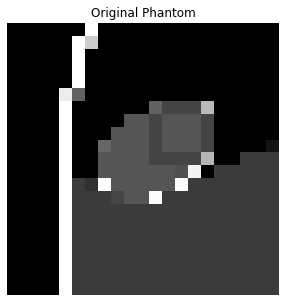

In [ ]:
# Initialize isochromat grid with 2D phantom and plot the phantom
grid = isoGrid(phantom2D)
plotMulti([phantom2D], ['Original Phantom'])


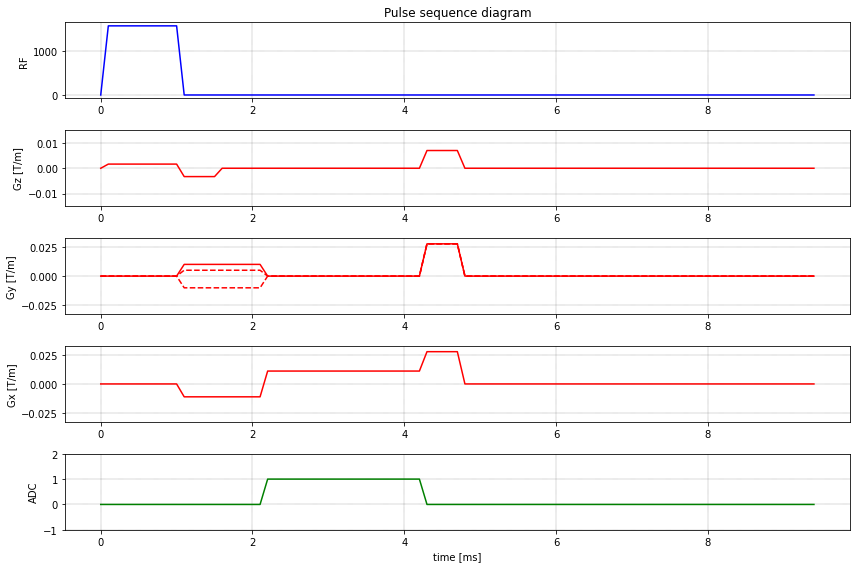

In [ ]:
# Set general parameters of the spGRE sequence
TR = 9.4e-3             # repetition time in [s]
nKx = grid.getSize(0)   # Number of frequency encoding steps
nKy = grid.getSize(1)   # Number of phase encoding steps

# Define sequence object (seq) with given parameters via Sequence class
seq = Sequence(TR, 0, nKx, nKy)

# Initialize RF field object (RF) via RFpulse class
# Input:
#   seq:    Sequence
#   fa:     Flip angle in degrees
#   tExc:   duration of RF pulse
#   t0Exc:  start time of RF pulse
RF = RFpulse(seq, fa = 90, tExc = 1e-3, t0Exc = 0)

# Set parameters for spGRE sequence
durPe       = np.ceil(nKx/2)*seq.dt  # Duration of phase encoding gradient
durSpoiler  = 0.5e-3                 # Duration of spoiler gradient

# Calculate field of view (FOV) and size of steps in k-Space dKx, dKy, dKz
FOV = np.multiply( np.asarray([nKx, nKy, 1]), seq.resolution )
dKx, dKy, dKz = 1 / FOV
dF = 0.7e+3 # Bandwidth [Hz]

# Set gradient amplitudes
Gx = dKx / (seq.gamma * seq.dt) # readout 
Gy = dKy / (seq.gamma * durPe)  # phase encoding 
Gz = dF / (seq.gamma * FOV[2])  # slice  

# Define gradient objects with given parameters via Gradient class
# Input:  Gradient(seq, strn, dur, t0, ax, steps)
#   seq:  Sequence object
#   strn: Gradient amplitude
#   dur:  Gradient duration         [s]
#   t0:   Start time within the TR  [s]
#   ax:   Gradient axis
#           0 : x-axis (readout)
#           1 : y-axis (phase)
#           2 : z-axis (slice)
#   steps: Number of gradient steps
Gsls    = Gradient(seq,      Gz,                      RF.tExc,     t0=0,                         ax=2,     steps=0)
Gslr    = Gradient(seq, -2 * Gz,                0.5 * RF.tExc,     t0=RF.tExc,                   ax=2,     steps=0)
Gpe     = Gradient(seq,      Gy,                      durPe,       t0=RF.tExc,                   ax=1,     steps=nKy)
Gdeph   = Gradient(seq,     -Gx,                      durPe,       t0=RF.tExc,                   ax=0,     steps=0)
Gra     = Gradient(seq,      Gx,                      nKx*seq.dt,  t0=RF.tExc+durPe,             ax=0,     steps=0)
Gspoil  = Gradient(seq,      np.min(seq.Gmax) * 0.8,  durSpoiler,  t0=RF.tExc+durPe+nKx*seq.dt,  ax=[0,1], steps=0)
Gspoil  = Gradient(seq,      np.min(seq.Gmax) * 0.2,  durSpoiler,  t0=RF.tExc+durPe+nKx*seq.dt,  ax=2,     steps=0)

# Set ADC Timing
seq.t0ADC = Gra.t0_dts * seq.dt

# Initialize sequence with defined RF pulse, gradients and ADC
seq.calculateSequence()
seq.plotSeq()

## Static phantom (no flow)
Here, the previously defined sequence is applied for the cardiac phantom in the static case, i.e. without flow.

In [ ]:
# Set flow order to 0 (no flow)
seq.fOrder = 0

# Set up a copy of the grid to save results without flow
gridNoFlow = copy.deepcopy(grid)

# Simulate sequence on grid without flow
gridNoFlow = seq.simSeq(gridNoFlow)

Simulating excitation...




Simulating acquisition...



## Phantom with flow - 1st order
Here, the previously defined sequence is applied for the cardiac phantom in the case where flow is present. Thereby, only first order effects are considered.

In [ ]:
# Set flow order to 1 (1st order flow effects, i.e. motion with constant velocity)
seq.fOrder = 1

# Set up a copy of the grid to save results with flow
gridFlow1 = copy.deepcopy(grid)

# Simulate sequence on grid with flow
gridFlow1 = seq.simSeq(gridFlow1)

Simulating excitation...




Simulating acquisition...



## Phantom with flow - 2nd order
Here, the previously defined sequence is applied for the cardiac phantom in the case where flow is present. Thereby, first and second order effects are considered.

In [ ]:
# Set flow order to 2 (2nd order flow effects, i.e. motion with constant acceleration)
seq.fOrder = 2

# Set up a copy of the grid to save results with flow
gridFlow2 = copy.deepcopy(grid)

# Simulate sequence on grid with flow
gridFlow2 = seq.simSeq(gridFlow2)

Simulating excitation...




Simulating acquisition...



## Results
In this last section, the previously simulated and reconstructed images are displayed.

### K-space results


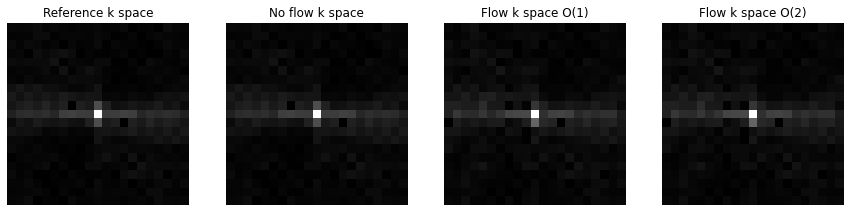

In [ ]:
# Compute reference k-space as Fourier transform of original phantom
kSpaceOri    = np.abs(np.fft.fftshift(np.fft.fft2(grid.M0[:,:,0,2])))

# Get simulated k-space from no flow and flow phantom
kSpaceNoFlow = np.abs(gridNoFlow.kSpace)
kSpaceFlow1  = np.abs(gridFlow1.kSpace)
kSpaceFlow2  = np.abs(gridFlow2.kSpace)

# Display results
titles = ["Reference k space", "No flow k space", "Flow k space O(1)", "Flow k space O(2)"]
plotMulti([kSpaceOri, kSpaceNoFlow, kSpaceFlow1, kSpaceFlow2], titles)


### Simulated scans

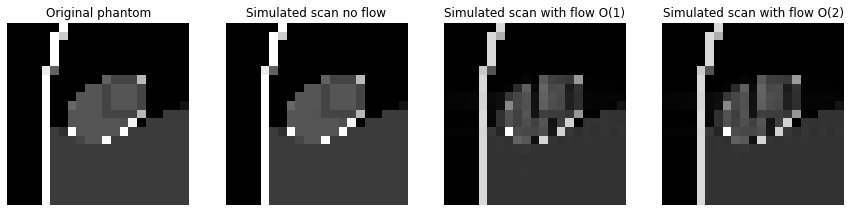

In [ ]:
# Reconstruct images from simulated k-Space without and with flow
scanNoFlow = np.abs(np.fft.fftshift(np.fft.ifft2(gridNoFlow.kSpace)))
scanFlow1 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlow1.kSpace)))
scanFlow2 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlow2.kSpace)))

# Display reconstructed images
titles = ["Original phantom", "Simulated scan no flow", "Simulated scan with flow O(1)", "Simulated scan with flow O(2)"]
plotMulti([phantom2D, scanNoFlow, scanFlow1, scanFlow2], titles)

## Phantom with flow and 1st order flow compensation (FC)

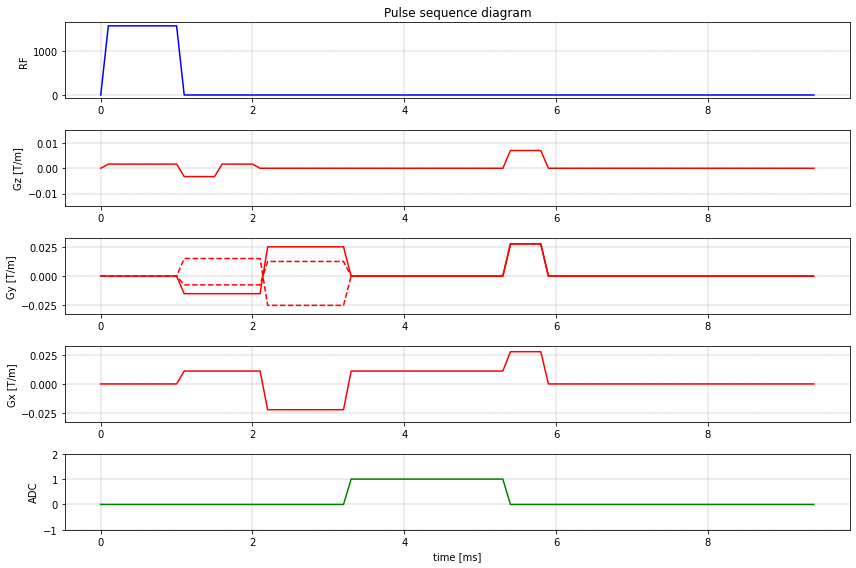

In [ ]:
# Set general parameters of the spGRE sequence
TR = 9.4e-3             # repetition time in [s]
nKx = grid.getSize(0)   # Number of frequency encoding steps
nKy = grid.getSize(1)   # Number of phase encoding steps

# Define sequence object (seq) with given parameters via Sequence class
seq = Sequence(TR, 0, nKx, nKy)

# Initialize RF field object (RF) via RFpulse class
# Input:
#   seq:    Sequence
#   fa:     Flip angle in degrees
#   tExc:   duration of RF pulse
#   t0Exc:  start time of RF pulse
RF = RFpulse(seq, fa = 90, tExc = 1e-3, t0Exc = 0)

# Set parameters for spGRE sequence
durPe       = np.ceil(nKx/2)*seq.dt  # Duration of phase encoding gradient
durSpoiler  = 0.5e-3                 # Duration of spoiler gradient

# Calculate field of view (FOV) and size of steps in k-Space dKx, dKy, dKz
FOV = np.multiply( np.asarray([nKx, nKy, 1]), seq.resolution )
dKx, dKy, dKz = 1 / FOV
dF = 0.7e+3 # Bandwidth [Hz]

# Set gradient amplitudes
Gx = dKx / (seq.gamma * seq.dt) # readout 
Gy = dKy / (seq.gamma * durPe)  # phase encoding 
Gz = dF / (seq.gamma * FOV[2])  # slice  

# Define gradient objects with given parameters via Gradient class
# Input:  Gradient(seq, strn, dur, t0, ax, steps)
#   seq:  Sequence object
#   strn: Gradient amplitude
#   dur:  Gradient duration         [s]
#   t0:   Start time within the TR  [s]
#   ax:   Gradient axis
#           0 : x-axis (readout)
#           1 : y-axis (phase)
#           2 : z-axis (slice)
#   steps: Number of gradient steps
Gsls    = Gradient(seq,      Gz,                      RF.tExc,     t0=0,                           ax=2,     steps=0)
Gcompz  = Gradient(seq, -2 * Gz,                0.5 * RF.tExc,     t0=RF.tExc,                     ax=2,     steps=0)
Gslr    = Gradient(seq,      Gz,                0.5 * RF.tExc,     t0=1.5*RF.tExc,                 ax=2,     steps=0)
Gcompy  = Gradient(seq, -3 *(Gy/2),                   durPe,       t0=RF.tExc,                     ax=1,     steps=nKy)
Gpe     = Gradient(seq,  5 *(Gy/2),                   durPe,       t0=RF.tExc+durPe,               ax=1,     steps=nKy)
Gcompx  = Gradient(seq,      Gx,                      durPe,       t0=RF.tExc,                     ax=0,     steps=0)
Gdeph   = Gradient(seq, -2 * Gx,                      durPe,       t0=RF.tExc+durPe,               ax=0,     steps=0)
Gra     = Gradient(seq,      Gx,                      nKx*seq.dt,  t0=RF.tExc+2*durPe,             ax=0,     steps=0)
Gspoil  = Gradient(seq,      np.min(seq.Gmax) * 0.8,  durSpoiler,  t0=RF.tExc+2*durPe+nKx*seq.dt,  ax=[0,1], steps=0)
Gspoil  = Gradient(seq,      np.min(seq.Gmax) * 0.2,  durSpoiler,  t0=RF.tExc+2*durPe+nKx*seq.dt,  ax=2,     steps=0)

# Set ADC Timing
seq.t0ADC = Gra.t0_dts * seq.dt

# Initialize sequence with defined RF pulse, gradients and ADC
seq.calculateSequence()
seq.plotSeq()

### Phantom with flow and FC - O(1)
Here, the previously defined sequence is applied for the cardiac phantom in the case where flow is present. Thereby, first order effects are considered.

In [ ]:
# Set flow order to 1 (1st order flow effects, i.e. motion with constant velocity)
seq.fOrder = 1

# Set up a copy of the grid to save results with flow
gridFlowComp1 = copy.deepcopy(grid)

# Simulate sequence on grid with flow
gridFlowComp1 = seq.simSeq(gridFlowComp1)

Simulating excitation...




Simulating acquisition...



## Results
In this last section, the previously simulated and reconstructed images are displayed.

### K-space results


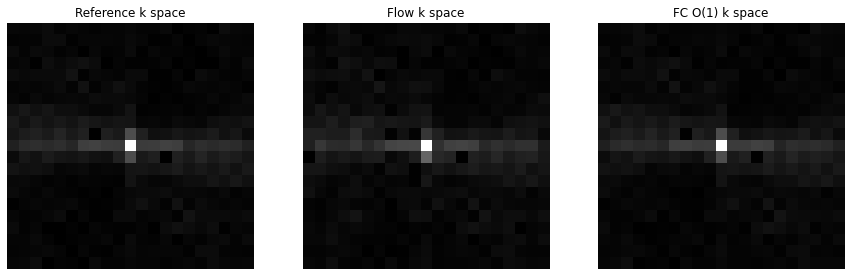

In [ ]:
# Compute reference k-space as Fourier transform of original phantom
kSpaceOri    = np.abs(np.fft.fftshift(np.fft.fft2(grid.M0[:,:,0,2])))

# Get simulated k-space from no flow and flow phantom
kSpaceNoFlow = np.abs(gridNoFlow.kSpace)
kSpaceFlow1   = np.abs(gridFlow1.kSpace)

# Get simulated k-space with flow and with flow comp
kSpaceFlowComp1 = np.abs(gridFlowComp1.kSpace)

# Display results
titles = ["Reference k space", "Flow k space", "FC O(1) k space"]
plotMulti([kSpaceOri, kSpaceFlow2, kSpaceFlowComp1], titles)


### Simulated scans

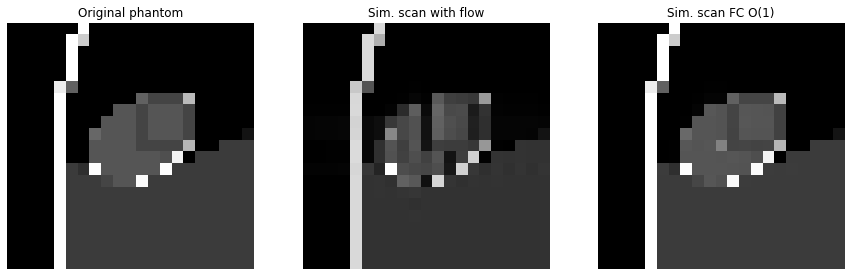

In [ ]:
# Reconstruct images from simulated k-Space without and with flow
scanNoFlow = np.abs(np.fft.fftshift(np.fft.ifft2(gridNoFlow.kSpace)))
scanFlow1 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlow1.kSpace)))

# reconstruct images with flow comp
scanFlowComp1 = np.abs(np.fft.fftshift(np.fft.ifft2(gridFlowComp1.kSpace)))

# Display reconstructed images
titles = ["Original phantom", "Sim. scan with flow", "Sim. scan FC O(1)"]
plotMulti([phantom2D, scanFlow2, scanFlowComp1], titles)
